In [1]:
import jscatter as js
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
import numpy as np
import matplotlib.pyplot as plt

^^^^^^^^^^^^^^ start fit ^^^^^^^^^^^^^^
chi^2 = 1.7006e+22 * 1 (limit weight) after 1 evaluations
contrast=  [1.] 
radius  =  [60.] 
-----fixed-----

fit finished after 0.0857 s   --->>   result   --->>
chi^2 = 2.0521e-06 * 1 (limit weight) after 95 evaluations
contrast=  [1.26882516e-06] 
radius  =  [62.05939846] 
-----fixed-----

degrees of freedom =  457
No Errors or zeros in Error!! Values are weighted equally! chi2 might not be closed to 1! 
_________fit successfully converged. We are done here !!__________
^^^^^^^^^^^^^^ start fit ^^^^^^^^^^^^^^
chi^2 = 49.729 * 1 (limit weight) after 1 evaluations
R       =  [62.05939846] 
gamma   =  [50.] 
scl     =  [100.] 
-----fixed-----
eta     =[0.48]

fit finished after 0.133 s   --->>   result   --->>
chi^2 = 28.067 * 1 (limit weight) after 40 evaluations
R       =  [61.60127113] 
gamma   =  [86.01416174] 
scl     =  [137.08889957] 
-----fixed-----
eta     =[0.48]

degrees of freedom =  456
nondiag correlation matrix maximum 0.0632 betwe

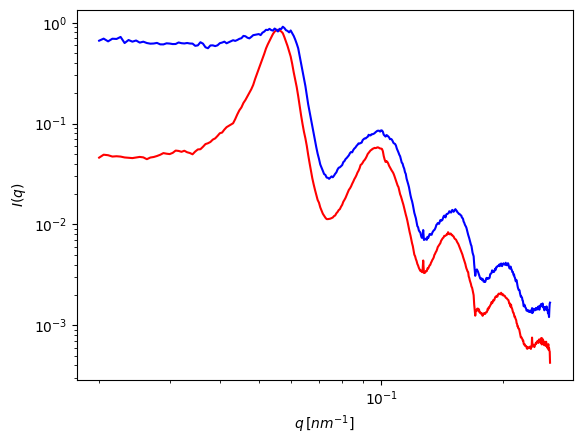

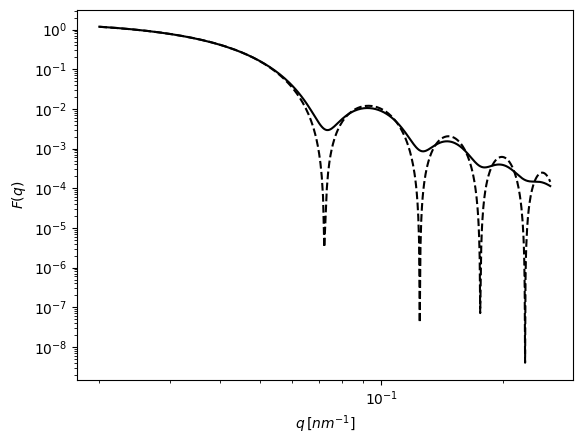

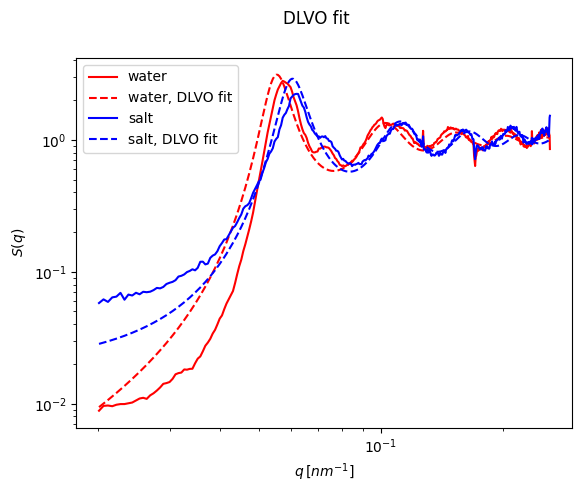

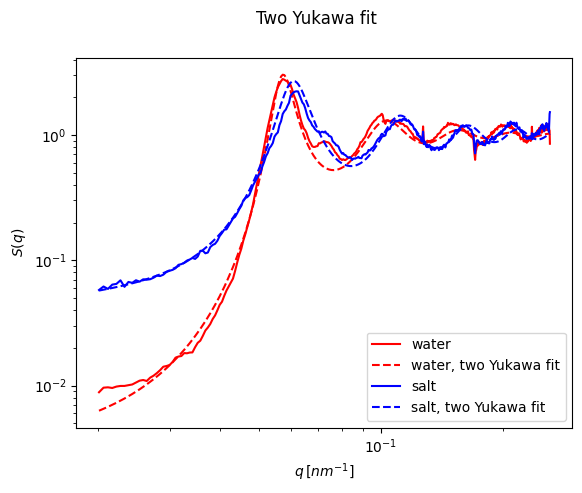

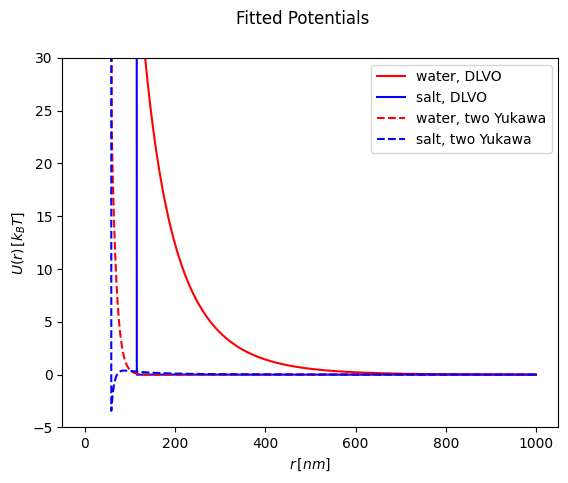

In [2]:
def DLVO(r, D, gamma, kappa):
    U = np.zeros(r.size)
    mask = r > D
    U[mask] = gamma * np.exp(-r[mask]*kappa) / (r[mask]/D)
    U[~mask] = 1e5
    return U

def twoYukawa(r, D, K1, K2, Z1, Z2):
    U = np.zeros(r.size)
    mask = r > D
    U[mask] = -K1 * np.exp(-Z1*(r[mask]/D-1))/(r[mask]/D) - K2 * np.exp(-Z2*(r[mask]/D-1))/(r[mask]/D)
    U[~mask] = 1e5
    return U

Factor_water = 4.4
Factor_salt = 9.7
lower_q = 2e-3    #1/Angstrom

data = np.loadtxt("IntensityProfile.csv", delimiter=",")
data = data[data[:,0] > lower_q]
data[:,0] *= 10
data_water = js.dA(data[:,(0,1,0)].T)   # third column save for yerr
data_salt = js.dA(data[:,(0,2,0)].T)    # third column save for yerr
formfactor = js.dA(data[:,(0,3)].T)

fig1, ax1 = plt.subplots(1)
ax1.plot(data_water.X, data_water.Y, 'r-')
ax1.plot(data_salt.X, data_salt.Y, 'b-')
ax1.set_xlabel(r'$q\/[nm^{-1}]$')
ax1.set_ylabel(r'$I(q)$')
ax1.set_xscale('log')
ax1.set_yscale('log')

formfactor.fit(model=js.ff.sphere, mapNames={'q':'X'}, freepar={'radius':60, 'contrast':1})
R = formfactor.lastfit.radius
#R = 60

fig2, ax2 = plt.subplots(1)
ax2.plot(formfactor.X, formfactor.Y, 'k-')
ax2.plot(formfactor.lastfit.X, formfactor.lastfit.Y, 'k--')
ax2.set_xlabel(r'$q\/[nm^{-1}]$')
ax2.set_ylabel(r'$F(q)$')
ax2.set_xscale('log')
ax2.set_yscale('log')

data_water.Y /= formfactor.Y * Factor_water
data_salt.Y /= formfactor.Y * Factor_salt
data_water.eY = data_water.Y * 0.1
data_salt.eY = data_salt.Y * 0.1
np.savetxt("Sq_water.txt", np.column_stack((data_water.X, data_water.Y)), header="q[1/nm]\tS(q)")
np.savetxt("Sq_salt.txt", np.column_stack((data_salt.X, data_salt.Y)), header="q[1/nm]\tS(q)")


### DLVO fit (i.e. single yukawa)
data_water.setlimit(R=(R-10,R+10), scl=(10,1000), gamma=(1,1000))
data_salt.setlimit(R=(R-10,R+10), scl=(10,100), gamma=(1,1000))
data_water.fit(model=js.sf.RMSA, mapNames={'q':'X'}, freepar={'R': R, 'scl':100, 'gamma':50}, fixpar={'eta': 0.48})
data_salt.fit(model=js.sf.RMSA, mapNames={'q':'X'}, freepar={'R': R, 'scl':10, 'gamma':10}, fixpar={'eta': 0.48})
fitresult_water_dlvo= "R = %f +/- %f;\tscl = %f +/- %f;\tgamma = %f +/- %f" % \
                      (data_water.lastfit.R, data_water.lastfit.R_err,
                       data_water.lastfit.scl, data_water.lastfit.scl_err,
                       data_water.lastfit.gamma, data_water.lastfit.gamma_err)
fitresult_salt_dlvo= "R = %f +/- %f;\tscl = %f +/- %f;\tgamma = %f +/- %f" % \
                     (data_salt.lastfit.R, data_salt.lastfit.R_err,
                      data_salt.lastfit.scl, data_salt.lastfit.scl_err,
                      data_salt.lastfit.gamma, data_salt.lastfit.gamma_err)
fig3, ax3 = plt.subplots(1)
fig3.suptitle('DLVO fit')
ax3.plot(data_water.X, data_water.Y, ls='-', color='r', label='water')
ax3.plot(data_water.lastfit.X, data_water.lastfit.Y, ls='--', color='r', label='water, DLVO fit')
ax3.plot(data_salt.X, data_salt.Y, ls='-', color='b', label='salt')
ax3.plot(data_salt.lastfit.X, data_salt.lastfit.Y, ls='--', color='b', label='salt, DLVO fit')
ax3.set_xlabel(r'$q\/[nm^{-1}]$')
ax3.set_ylabel(r'$S(q)$')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend()
fig3.savefig("Sq_DLVO_fit.png")

### DLVO fitted potential
r = np.linspace(0,1000,10000)
U_dlvo_water = DLVO(r, data_water.lastfit.R*2, data_water.lastfit.gamma, 1.0/data_water.lastfit.scl)
U_dlvo_salt = DLVO(r, data_salt.lastfit.R*2, data_salt.lastfit.gamma, 1.0/data_salt.lastfit.scl)


### two yukawa fit
data_water.setlimit(R=(R-10,R+10), scl1=(0,100), scl2=(0,100), K1=(0,100), K2=(-100,0))
data_salt.setlimit(R=(R-10,R+10), scl1=(0,100), scl2=(0,100), K1=(0,100), K2=(-100,0))
data_water.fit(model=js.sf.twoYukawa, mapNames={'q':'X'}, freepar={'R':R, 'K1':1, 'K2':-20, 'scl1':0.1, 'scl2':1}, fixpar={'phi': 0.48})
data_salt.fit(model=js.sf.twoYukawa, mapNames={'q':'X'},  freepar={'R':R, 'K1':5, 'K2':-1, 'scl1':0.1, 'scl2':1}, fixpar={'phi': 0.48})
fitresult_water_2yukawa = "R = %f +/- %f;\tscl1 = %f +/- %f;\tK1 = %f +/- %f;\tscl2 = %f +/- %f;\tK2 = %f +/- %f" % \
                          (data_water.lastfit.R, data_water.lastfit.R_err,
                           data_water.lastfit.scl1, data_water.lastfit.scl1_err,
                           data_water.lastfit.K1, data_water.lastfit.K1_err,
                           data_water.lastfit.scl2, data_water.lastfit.scl2_err,
                           data_water.lastfit.K2, data_water.lastfit.K2_err,)
fitresult_salt_2yukawa = "R = %f +/- %f;\tscl1 = %f +/- %f;\tK1 = %f +/- %f;\tscl2 = %f +/- %f;\tK2 = %f +/- %f" % \
                         (data_salt.lastfit.R, data_salt.lastfit.R_err,
                          data_salt.lastfit.scl1, data_salt.lastfit.scl1_err,
                          data_salt.lastfit.K1, data_salt.lastfit.K1_err,
                          data_salt.lastfit.scl2, data_salt.lastfit.scl2_err,
                          data_salt.lastfit.K2, data_salt.lastfit.K2_err,)
fig4, ax4 = plt.subplots(1)
fig4.suptitle('Two Yukawa fit')
ax4.plot(data_water.X, data_water.Y, ls='-', color='r', label='water')
ax4.plot(data_water.lastfit.X, data_water.lastfit.Y, ls='--', color='r', label='water, two Yukawa fit')
ax4.plot(data_salt.X, data_salt.Y, ls='-', color='b', label='salt')
ax4.plot(data_salt.lastfit.X, data_salt.lastfit.Y, ls='--', color='b', label='salt, two Yukawa fit')
ax4.set_xlabel(r'$q\/[nm^{-1}]$')
ax4.set_ylabel(r'$S(q)$')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.legend()
fig4.savefig("Sq_TwoYukawa_fit.png")

### two yukawa fitted potential
r = np.linspace(0,1000,10000)
U_2yukawa_water = twoYukawa(r, data_water.lastfit.R, data_water.lastfit.K1, data_water.lastfit.K2, 1.0/data_water.lastfit.scl1, 1.0/data_water.lastfit.scl2)
U_2yukawa_salt = twoYukawa(r, data_salt.lastfit.R, data_salt.lastfit.K1, data_salt.lastfit.K2, 1.0/data_salt.lastfit.scl1, 1.0/data_salt.lastfit.scl2)


### plot fitted potentials
fig5, ax5 = plt.subplots(1)
fig5.suptitle("Fitted Potentials")
ax5.plot(r, U_dlvo_water, color='r', ls='-', label='water, DLVO')
ax5.plot(r, U_dlvo_salt, color='b', ls='-', label='salt, DLVO')
ax5.plot(r, U_2yukawa_water, color='r', ls='--', label='water, two Yukawa')
ax5.plot(r, U_2yukawa_salt, color='b', ls='--', label='salt, two Yukawa')
ax5.set_xlabel(r'$r\/[nm]$')
ax5.set_ylabel(r'$U(r) \/ [k_{B}T]$')
ax5.set_ylim([-5,30])
ax5.legend()
fig5.savefig("Fitted_Potential.png")


print("water, DLVO: ", fitresult_water_dlvo)
print("salt, DLVO:  ", fitresult_salt_dlvo)
print("water two Yukawa: ", fitresult_water_2yukawa)
print("salt two Yukawa: ", fitresult_salt_2yukawa)
plt.show(block=True)

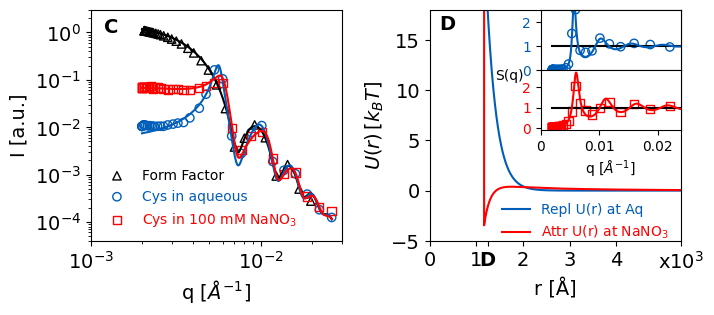

In [3]:
p2color = '#FF0000'
p1color = '#005EB8'
p1marker = 'o'
p2marker = 's'

PlotNotation = ['C', 'D', 'E']

# Get the RGB values for the cividis colormap
cividis_cmap = plt.get_cmap('cividis')


Data = np.loadtxt('IntensityProfile.csv',delimiter=',')
q = Data[36:,0]
I = Data[36:,1]
FormFactor = Data[36:,3]

ExpData = np.loadtxt('FormFactorExp.csv',delimiter=',')
Expq = ExpData[35:,0]
ExpI = ExpData[35:,1]

f = plt.figure(figsize=(12,3))
ax = f.add_subplot(131)
ax.text(1.2e-3,1,PlotNotation[0], fontsize=14, weight='bold')
ax.plot(q,FormFactor,color='k')

SelectedIdx = np.logspace(np.log10(1),np.log10(459),35).astype(int) - 1
ax.scatter(Expq[SelectedIdx],ExpI[SelectedIdx],color='k',label='Form Factor',marker='^',facecolor='none')


SelectedIdx = np.logspace(np.log10(1),np.log10(459),35).astype(int) - 1
Factor = 4.4 
ax.scatter(q[SelectedIdx],I[SelectedIdx] / Factor,color=p1color,facecolor='none',marker=p1marker,label='Cys in aqueous')
ax.plot(data_water.lastfit.X / 10, data_water.lastfit.Y * formfactor.Y, color=p1color)

I = Data[36:,2]
Factor = 9.7
ax.scatter(q[SelectedIdx],I[SelectedIdx] / Factor,color=p2color,facecolor='none',marker=p2marker,label='Cys in 100 mM NaNO$_{3}$')
ax.plot(data_salt.lastfit.X / 10, data_salt.lastfit.Y * formfactor.Y, color=p2color)

# popt, pcov = curve_fit(js.sf.RMSA, q, I/FormFactor)
# ax1.plot(q,js.sf.RMSA(q,*popt),color=plcolor,ls='--')
ax.set_xlim(1e-3,3e-2)
ax.set_ylim(4e-5,3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('q [$Å^{-1}$]',fontsize=14)
ax.set_ylabel('I [a.u.]',fontsize=14)
ax.tick_params(axis='both',which='both',labelsize=14)
ax.legend(loc='lower center',framealpha=0)


legend = ax.legend(framealpha=0,loc='lower left')
# Change the color of the legend text
legend.get_texts()[1].set_color(p1color)  # Set the color of the first legend item
legend.get_texts()[2].set_color(p2color)  # Set the color of the second legend item



ax1 = f.add_subplot(132)
ax1.text(200,16,PlotNotation[1], fontsize=14, weight='bold')
Factor = 4.4

### two yukawa fitted potential
r = np.linspace(0,1000,10000)
U_2yukawa_water = twoYukawa(r, data_water.lastfit.R*2, data_water.lastfit.K1, data_water.lastfit.K2, 1.0/data_water.lastfit.scl1, 1.0/data_water.lastfit.scl2)
U_2yukawa_salt = twoYukawa(r, data_salt.lastfit.R*2, data_salt.lastfit.K1, data_salt.lastfit.K2, 1.0/data_salt.lastfit.scl1, 1.0/data_salt.lastfit.scl2)

ax1.plot(r * 10, U_2yukawa_water, color=p1color, label='Repl U(r) at Aq')
Factor = 9.7
ax1.plot(r * 10, U_2yukawa_salt, color=p2color, label='Attr U(r) at NaNO$_{3}$')
ax1.set_xlabel('r [Å]',fontsize=14)
ax1.set_ylabel(r'$U(r) \/ [k_{B}T]$',fontsize=14)
ax1.set_ylim([-5,18])
ax1.set_xlim([0, 5400])
ax1.set_xticks(     [0 , 1000, R*20, 2000, 3000, 4000, 5400])
ax1.set_xticklabels([0 , 1, 'D',  2,    3,    4,    'x10$^{3}$'])
ax1.tick_params(axis='both',which='both',labelsize=14)

legend_x = 1.0  # X-coordinate of the legend
legend_y = 0.22  # Y-coordinate of the legend
# Create the legend
legend = ax1.legend(framealpha=0,bbox_to_anchor=(legend_x, legend_y))
legend.get_texts()[0].set_color(p1color)  # Set the color of the first legend item
legend.get_texts()[1].set_color(p2color)  # Set the color of the second legend item

# Get the current xtick labels
xtick_labels = ax1.get_xticklabels()

# Set the desired label to be bold (e.g., the second label)
bold_label_index = 2
xtick_labels[bold_label_index].set_fontweight('bold')

# Set the updated xtick labels
ax1.set_xticklabels(xtick_labels)
ax1.text(1400,11,'S(q)')

ax2 = plt.axes([0.50, 0.68, 0.117, 0.2])
ax2.plot(data_salt.lastfit.X/ 10,np.ones(data_salt.lastfit.X.shape),color='k')
ax2.scatter(data_water.X[SelectedIdx] / 10, data_water.Y[SelectedIdx], color=p1color,marker=p1marker,facecolor='none', label='water')
ax2.plot(data_water.lastfit.X / 10, data_water.lastfit.Y, color=p1color)
ax2.set_xlim([0, 0.024])
ax2.set_ylim([0, 2.5])
ax2.set_yticks([0 , 1 , 2])
ax2.set_yticklabels([0 , 1 ,2], color=p1color)
ax2.set_xticks([])
ax2.set_xticklabels([])

ax2 = plt.axes([0.50, 0.48, 0.117, 0.2])
ax2.plot(data_salt.lastfit.X/ 10,np.ones(data_salt.lastfit.X.shape),color='k')
ax2.scatter(data_salt.X[SelectedIdx] / 10, data_salt.Y[SelectedIdx], color=p2color,marker=p2marker,facecolor='none', label='salt')
ax2.plot(data_salt.lastfit.X/ 10, data_salt.lastfit.Y, color=p2color)
ax2.set_xlim([0, 0.024])
ax2.set_yticks([0 , 1 , 2])
ax2.set_yticklabels([0 , 1 ,2], color=p2color)
ax2.set_xticks([0, 0.01, 0.02])
ax2.set_xticklabels([0, 0.01, 0.02])
ax2.set_xlabel('q [$Å^{-1}$]')

plt.subplots_adjust(hspace=0.3, wspace=0.35)
plt.savefig('fig1_SAXS.png', dpi=600, bbox_inches='tight')